In [1]:
from PMTO import BayesianOptimization, ObjectiveFunction, \
    MultiObjectiveFunction, MultiObjectiveBayesianOptimization, \
    ContextualBayesianOptimization, ContextualMultiObjectiveFunction, \
    ContextualMultiObjectiveBayesianOptimization
import torch
import matplotlib.pyplot as plt


# Test Case for GP-SOO
def test_bo():
    cur_dim = 5
    objective = ObjectiveFunction(func_name='ackley', dim=cur_dim)
    X_train = torch.rand(50, cur_dim)
    y_train = torch.tensor([objective.evaluate(x) for x in X_train])

    # print(X_train.shape, y_train.shape)

    inducing_points = torch.rand(20, cur_dim)
    bo = BayesianOptimization(objective_func=objective,
                              inducing_points=inducing_points,
                              model_type="EXACT-GP",
                              optimizer_type="adam")

    X_final, y_final, best_y = bo.optimize(X_train, y_train, n_iter=100, beta=1.0)

In [2]:
def test_mobo():
    """Test cases for Multi-Objective Bayesian Optimization"""
    print("\nTesting Multi-Objective Bayesian Optimization...")

    # Create test problem
    n_var = 7
    n_obj = 2
    problem = MultiObjectiveFunction(
        func_name='dtlz3',
        n_objectives=n_obj,
        n_variables=n_var
    )

    # Initial training data
    X_train = torch.rand(50, n_var)
    Y_train = problem.evaluate(X_train)

    # Set reference point for hypervolume calculation
    # ref_point = torch.ones(n_obj) * 1.1  # Slightly above maximum possible value

    # Initialize MOBO
    # inducing_points = torch.rand(20, n_var)
    print(problem.output_dim)
    mobo = MultiObjectiveBayesianOptimization(
        objective_func=problem,
        # reference_point=ref_point,
        # inducing_points=inducing_points,
        model_type="EXACT-GP",
        optimizer_type="adam"
    )

    # Run optimization
    X_final, Y_final = mobo.optimize(
        X_train=X_train,
        Y_train=Y_train,
        n_iter=50,
        beta=2.0
    )
    hv_history = mobo.hv_history

    print(f"\nMOBO Results:")
    print(f"Initial points: {len(X_train)}")
    print(f"Final points: {len(X_final)}")
    print(f"Initial HV: {hv_history[0]:.3f}")
    print(f"Final HV: {hv_history[-1]:.3f}")

    # Visualize optimization progress
    plt.figure(figsize=(15, 5))

    # Plot hypervolume history
    plt.subplot(1, 2, 1)
    plt.plot(hv_history)
    plt.title('Hypervolume Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Hypervolume')

    # Plot final Pareto front approximation
    plt.subplot(1, 2, 2)
    plt.scatter(Y_final[:, 0].numpy(), Y_final[:, 1].numpy(),
                c='blue', label='All points')
    pareto_front = mobo.pareto_front
    plt.scatter(pareto_front[:, 0].numpy(),
                pareto_front[:, 1].numpy(),
                c='red', label='Pareto front')
    plt.title('Final Pareto Front Approximation')
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3]:
def test_multiobjective_functions():
    """Test cases for DTLZ test problems"""
    print("Testing DTLZ test problems...")

    # Test DTLZ1 with 2 objectives
    n_var = 7  # n = m + k - 1, where m=2, k=6
    problem = MultiObjectiveFunction(
        func_name='dtlz1',
        n_objectives=2,
        n_variables=n_var
    )

    # Generate test points
    X_test = torch.rand(50, n_var)
    Y_test = problem.evaluate(X_test)

    print(f"\nDTLZ1 Test:")
    print(f"Input shape: {X_test.shape}")
    print(f"Output shape: {Y_test.shape}")
    print(f"Output range: [{Y_test.min():.3f}, {Y_test.max():.3f}]")

    # Test DTLZ2 with 3 objectives
    n_var = 12  # n = m + k - 1, where m=3, k=10
    problem = MultiObjectiveFunction(
        func_name='dtlz2',
        n_objectives=2,
        n_variables=n_var
    )

    X_test = torch.rand(50, n_var)
    Y_test = problem.evaluate(X_test)

    print(f"\nDTLZ2 Test:")
    print(f"Input shape: {X_test.shape}")
    print(f"Output shape: {Y_test.shape}")
    print(f"Output range: [{Y_test.min():.3f}, {Y_test.max():.3f}]")

    # Visualize 2D results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    problem_2d = MultiObjectiveFunction('dtlz1', n_objectives=2)
    X_vis = torch.rand(100, problem_2d.n_variables)
    Y_vis = problem_2d.evaluate(X_vis)
    plt.scatter(Y_vis[:, 0].numpy(), Y_vis[:, 1].numpy())
    plt.title('DTLZ1 (2 objectives)')
    plt.xlabel('f1')
    plt.ylabel('f2')

    plt.subplot(1, 2, 2)
    problem_2d = MultiObjectiveFunction('dtlz2', n_objectives=2)
    Y_vis = problem_2d.evaluate(X_vis)
    plt.scatter(Y_vis[:, 0].numpy(), Y_vis[:, 1].numpy())
    plt.title('DTLZ2 (2 objectives)')
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.tight_layout()
    plt.show()


In [4]:
def test_dimensions():
    """Test if context dimensions are correctly set based on k = n - m + 1"""
    print("Testing problem dimensions...")
    
    test_cases = [
        {'func': 'dtlz1', 'm': 2, 'n': 6},
        {'func': 'dtlz2', 'm': 3, 'n': 8},
        {'func': 'dtlz3', 'm': 2, 'n': 10}
    ]
    
    for case in test_cases:
        problem = ContextualMultiObjectiveFunction(
            func_name=case['func'],
            n_objectives=case['m'],
            n_variables=case['n']
        )
        
        # Calculate expected k
        expected_k = case['n'] - case['m'] + 1
        
        print(f"\n{case['func'].upper()} with m={case['m']}, n={case['n']}:")
        print(f"Expected context dim (k): {expected_k}")
        print(f"Actual context dim: {problem.context_dim}")
        assert problem.context_dim == expected_k, f"Context dimension mismatch in {case['func']}"
        
        # Test input dimension handling
        n_samples = 5
        X = torch.rand(n_samples, problem.n_variables)
        C = torch.rand(n_samples, problem.context_dim)
        inputs = torch.cat([X, C], dim=1)
        
        try:
            Y = problem.evaluate(inputs)
            print(f"Input shape: {inputs.shape}")
            print(f"Output shape: {Y.shape}")
            assert Y.shape == (n_samples, case['m']), f"Output dimension mismatch in {case['func']}"
            print("Dimension test passed!")
        except Exception as e:
            print(f"Error in {case['func']}: {str(e)}")

test_dimensions()

Testing problem dimensions...

DTLZ1 with m=2, n=6:
Expected context dim (k): 5
Actual context dim: 5
Error in dtlz1: expand(torch.FloatTensor{[5, 5]}, size=[5]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

DTLZ2 with m=3, n=8:
Expected context dim (k): 6
Actual context dim: 6
Error in dtlz2: expand(torch.FloatTensor{[5, 5]}, size=[5]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

DTLZ3 with m=2, n=10:
Expected context dim (k): 9
Actual context dim: 9
Error in dtlz3: expand(torch.FloatTensor{[5, 5]}, size=[5]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)



Running visualization tests...

Testing DTLZ1
Testing with 2 objectives

Problem settings:
n_variables (n): 11
n_objectives (m): 2
context_dim (k): 10 (should be n-m+1)


RuntimeError: expand(torch.FloatTensor{[500, 500]}, size=[500]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

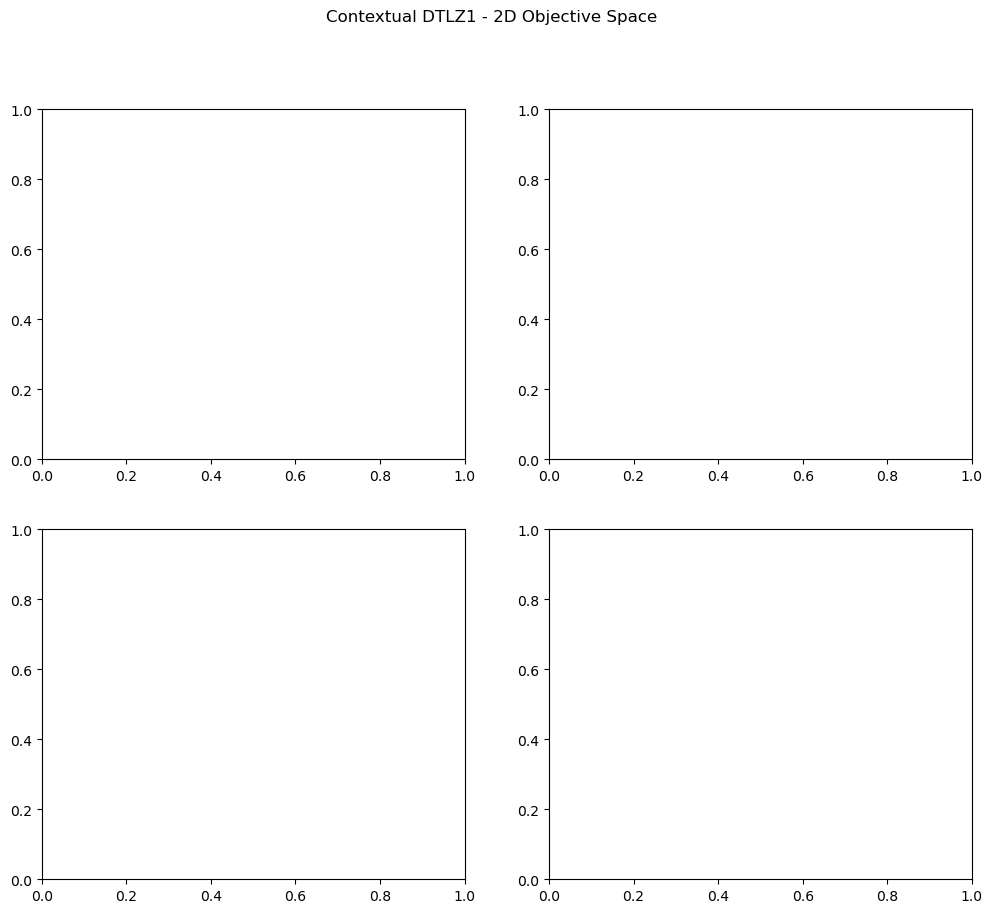

In [6]:
def visualize_contextual_effects(func_name='dtlz1', n_objectives=2, n_samples=500):
    """Visualize the effects of different contexts on the objective space."""
    problem = ContextualMultiObjectiveFunction(
        func_name=func_name,
        n_objectives=n_objectives
    )
    
    # Verify context dimension
    k = problem.context_dim
    print(f"\nProblem settings:")
    print(f"n_variables (n): {problem.n_variables}")
    print(f"n_objectives (m): {problem.n_objectives}")
    print(f"context_dim (k): {k} (should be n-m+1)")
    
    # Generate different contexts
    contexts = [
        torch.zeros(1, k),     # Zero context
        torch.ones(1, k),      # One context
        torch.rand(1, k),      # Random context
        0.5 * torch.ones(1, k) # Mid context
    ]
    context_names = ['Zero Context', 'One Context', 'Random Context', 'Mid Context']
    
    # Setup plotting
    if n_objectives == 2:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        fig.suptitle(f'Contextual {func_name.upper()} - 2D Objective Space')
        
        for idx, (context, name) in enumerate(zip(contexts, context_names)):
            # Generate random samples
            X = torch.rand(n_samples, problem.n_variables)
            C = context.repeat(n_samples, 1)
            
            # Verify dimensions
            assert C.shape[1] == k, f"Context dimension mismatch: {C.shape[1]} != {k}"
            
            inputs = torch.cat([X, C], dim=1)
            Y = problem.evaluate(inputs)
            
            axes[idx].scatter(Y[:, 0].numpy(), Y[:, 1].numpy(), alpha=0.5)
            axes[idx].set_xlabel('f1')
            axes[idx].set_ylabel('f2')
            axes[idx].set_title(f'{name}\nShift:{problem.get_context_shift(context)[0,0]:.2f}, '
                              f'Power:{problem.get_context_power(context)[0]:.2f}')
    
    elif n_objectives == 3:
        fig = plt.figure(figsize=(15, 10))
        fig.suptitle(f'Contextual {func_name.upper()} - 3D Objective Space')
        
        for idx, (context, name) in enumerate(zip(contexts, context_names)):
            ax = fig.add_subplot(2, 2, idx+1, projection='3d')
            
            X = torch.rand(n_samples, problem.n_variables)
            C = context.repeat(n_samples, 1)
            
            assert C.shape[1] == k, f"Context dimension mismatch: {C.shape[1]} != {k}"
            
            inputs = torch.cat([X, C], dim=1)
            Y = problem.evaluate(inputs)
            
            ax.scatter(Y[:, 0].numpy(), Y[:, 1].numpy(), Y[:, 2].numpy(), alpha=0.5)
            ax.set_xlabel('f1')
            ax.set_ylabel('f2')
            ax.set_zlabel('f3')
            ax.set_title(f'{name}\nShift:{problem.get_context_shift(context)[0,0]:.2f}, '
                        f'Power:{problem.get_context_power(context)[0]:.2f}')
    
    plt.tight_layout()
    plt.show()

print("\nRunning visualization tests...")
for func_name in ['dtlz1', 'dtlz2', 'dtlz3']:
    print(f"\nTesting {func_name.upper()}")
    for n_obj in [2, 3]:
        print(f"Testing with {n_obj} objectives")
        visualize_contextual_effects(func_name, n_objectives=n_obj)


Testing Multi-Objective Bayesian Optimization...
2
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])
2
torch.Size([7])

MOBO Results:
Initial points: 50
Final points: 

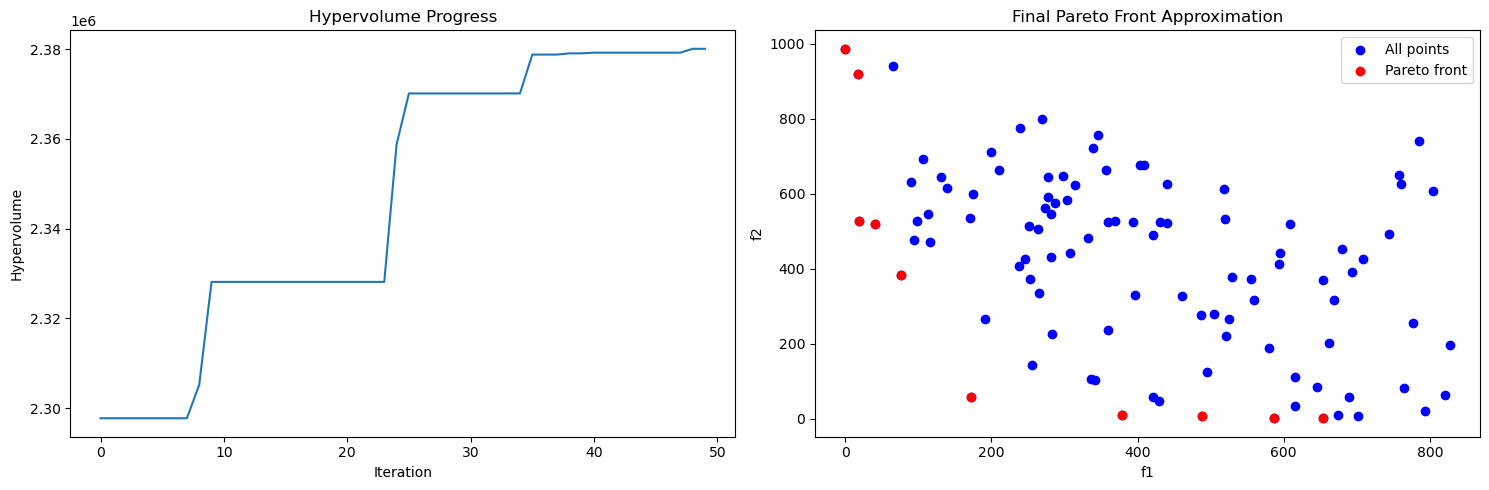

In [4]:
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    # np.random.seed(42)

    # Run tests
    # test_bo()
    # test_multiobjective_functions()
    test_mobo()